In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv('listings_cleaned.csv', index_col = 'id')
df.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,city,property_type,...,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,event_suitable,time_since_first_review,time_since_last_review
id,,,,,,,,,,,,,,,,,,,,,
2265,2008-08-23,within a few hours,100%,100%,1.0,2-3,1.0,78702,AUSTIN,HOUSE,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,4+ years,6-12 months
5245,2008-08-23,within a few hours,100%,100%,1.0,2-3,1.0,78702,AUSTIN,HOUSE,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4+ years,1-2 years
5456,2009-02-16,within a few hours,100%,98%,1.0,1,1.0,78702,AUSTIN,HOUSE,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4+ years,0-6 months
5769,2009-02-19,unknown,unknown,93%,1.0,1,1.0,78729,AUSTIN,HOUSE,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4+ years,0-6 months
6413,2009-04-17,within an hour,100%,100%,1.0,1,0.0,78704,AUSTIN,HOUSE,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4+ years,0-6 months


# EDA

1. Which areas/neighborhoods in Austin, TX are the most expensive and have the
most listings?
2. What are the most common listing types? (ie: entire home/apartment or shared
space?)
3. How long have different hosts been listing properties through Airbnb and how
many listings do host’s have on average?
4. How do Airbnb prices correlate with the number of people a listing
accommodates?
5. How favorable are reviews and what do the distributions look like?
6. What are the most common amenities, and which amenities are likely to increase
the price of a listing?
7. What is the value of being a superhost? Is it worth getting verified?

_**1. Which areas/neighborhoods in Austin, TX are the most expensive and have the most listings?**_

In [5]:
# Importing the Austin borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods.geojson')
map_df = map_df.drop('neighbourhood_group', axis=1)
map_df = map_df.rename(columns = {'neighbourhood': 'zip_code'})
map_df['zip_code'] = map_df['zip_code'].astype('int64')
map_df = map_df.set_index('zip_code')

In [6]:
# Creating a dataframe of listing counts and median price by zip_code
df = df.rename(columns={'neighbourhood_cleansed' : 'zip_code'})
zip_df = pd.DataFrame(df.groupby('zip_code').size())
zip_df.rename(columns={0: 'number_of_listings'}, inplace=True)
zip_df['median_price'] = df.groupby('zip_code').price.median().values

# Joining the dataframes
zip_map_df = map_df.join(zip_df)

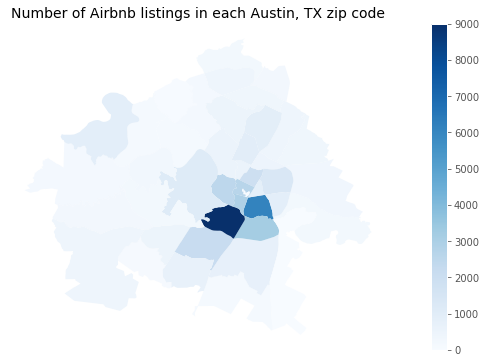

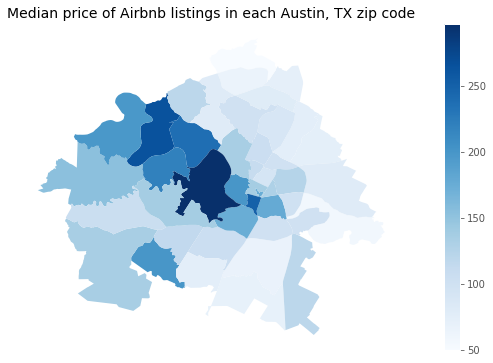

In [7]:
# Plotting the number of listings in each zip code
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
zip_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Austin, TX zip code', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each zip code
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
zip_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Austin, TX zip code', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(zip_map_df.median_price), vmax=max(zip_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

_**2. What are the most common listing types? (ie: entire home/apartment or shared space?)**_

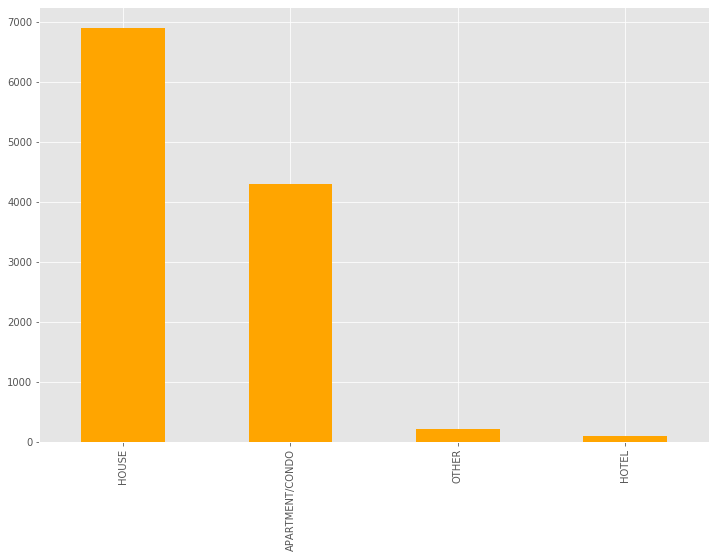

In [8]:
df.property_type.value_counts().plot(kind='bar', color = 'orange')

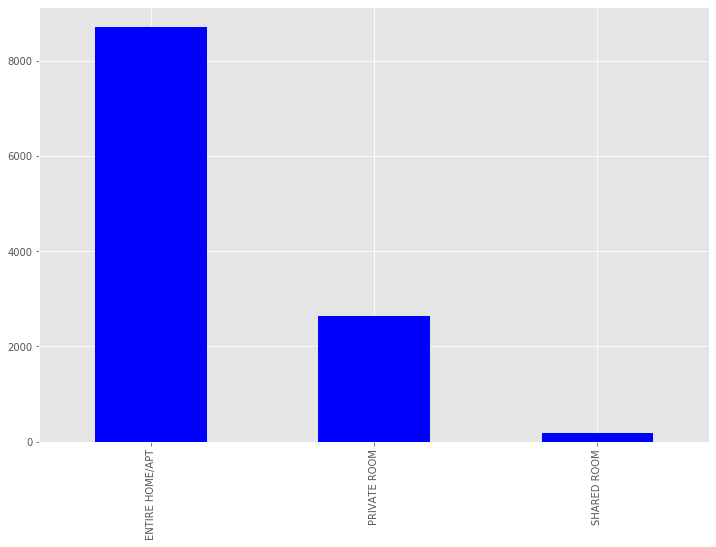

In [9]:
df.room_type.value_counts().plot(kind='bar', color = 'blue')

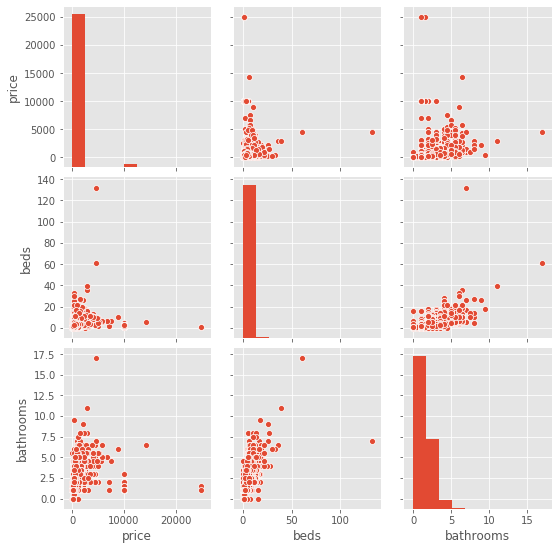

In [10]:
pairplt_features = ['price', 'beds', 'bathrooms']
pairplt_df = df[pairplt_features]
sns.pairplot(pairplt_df)

_**3. How long have different hosts been listing properties through Airbnb and how many listings do host’s have on average?**_

In [11]:
# Converting to datetime object
df['host_since'] = pd.to_datetime(df['host_since'])
# Calcuating the number of days a host has been active on Airbnb
# I used 2/19/2020 as the end date since that was the date this data was scraped
df['days_as_host'] = (dt(2020, 2, 19) - df.host_since).astype('timedelta64[D]')

#Creating a new column that shows the time in number of days since a listings first review
df.first_review = pd.to_datetime(df.first_review)
df['days_since_first_review'] = (dt(2020, 2, 19) - df.first_review)

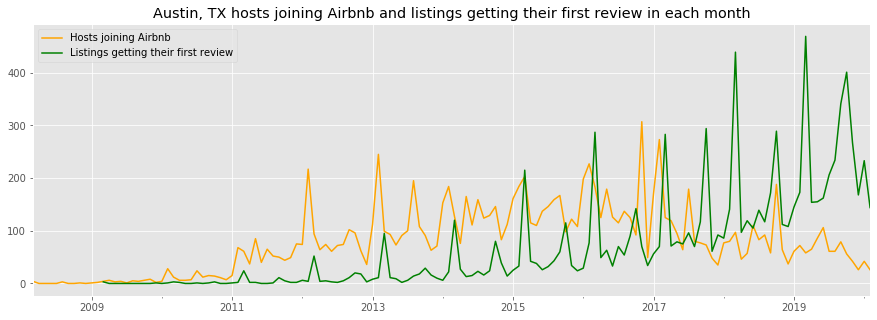

In [12]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('M').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('M').size().plot(label='Listings getting their first review', color='green')
plt.title('Austin, TX hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-03-08', '2020-02-19')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [13]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [14]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

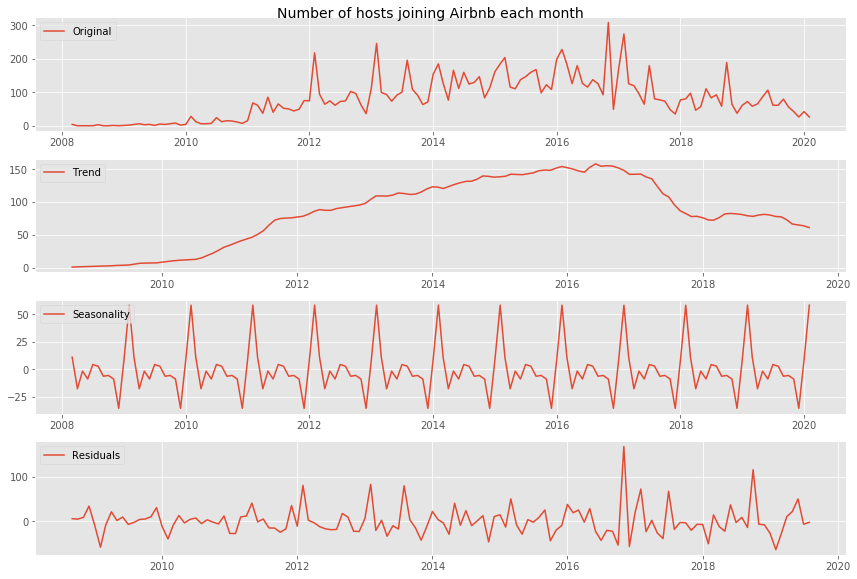

In [15]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

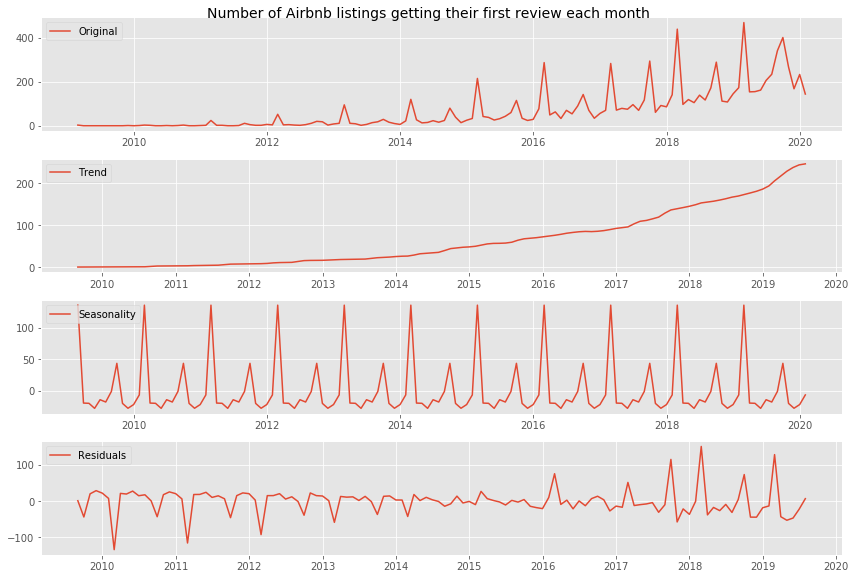

In [16]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

_**4. How do Airbnb prices correlate with the number of people a listing
accommodates?**_

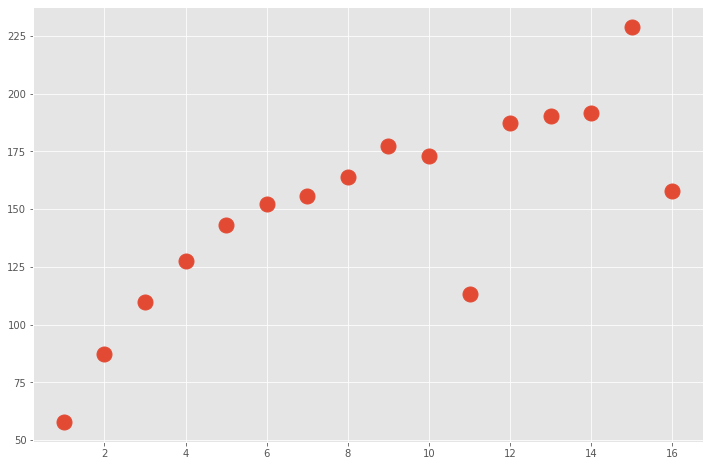

In [19]:
filtered_price = df[df['price']<=250]
pivot_price = pd.pivot_table(filtered_price, values='price', index='accommodates')
plt.plot(pivot_price, linestyle='none', marker='.', markersize=30)

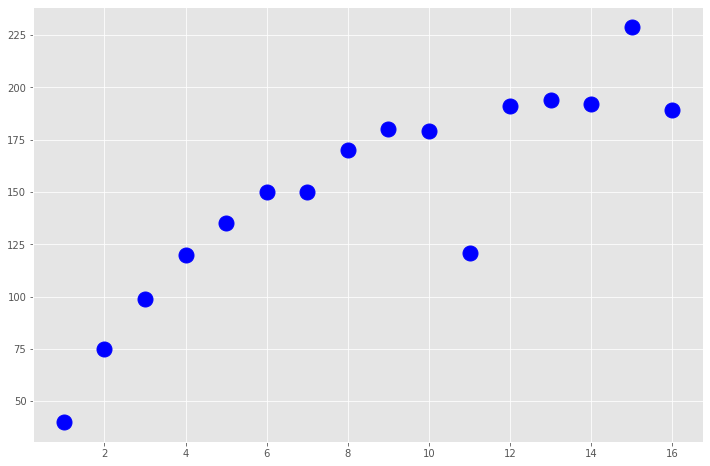

In [20]:
pivot_price = pd.pivot_table(filtered_price, values='price', index='accommodates', aggfunc='median')
plt.plot(pivot_price, linestyle='none', marker='.', markersize=30, color='b')

_**5. How favorable are reviews and what do the distributions look like?**_

In [21]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

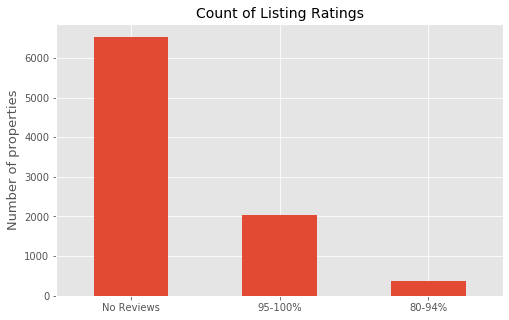

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Count of Listing Ratings', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', ax=ax)
ax.set_ylabel('Number of properties', fontsize=13)
ax.set_xticklabels(labels=['No Reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
plt.show()

It is clear that in general, people give high review scores.

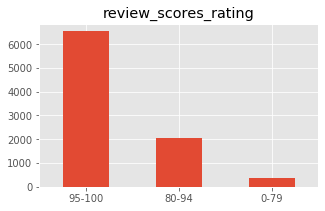

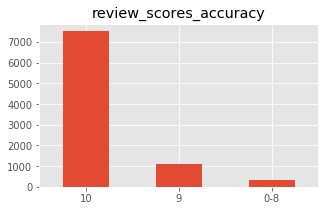

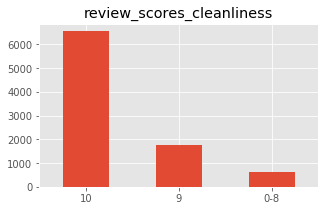

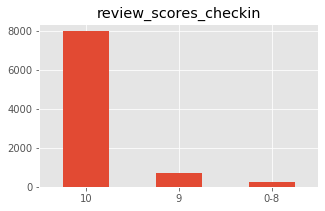

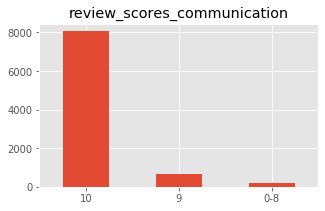

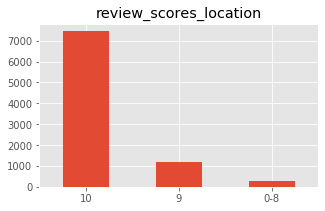

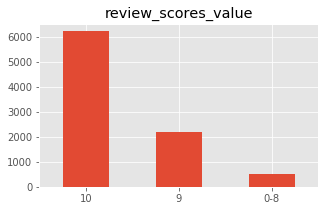

In [24]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

_**6. What are the most common amenities, and which amenities are likely to increase**_

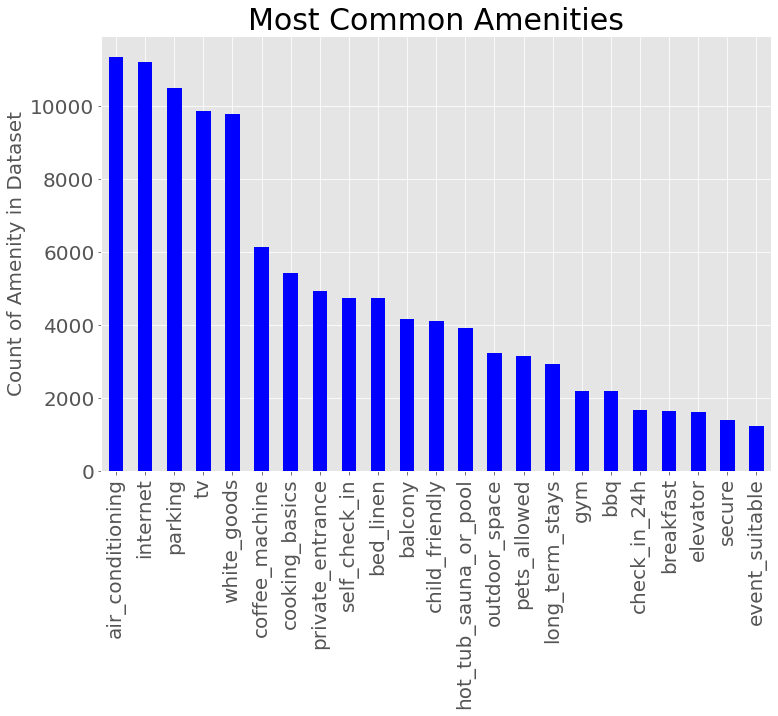

In [25]:
plt.title('Most Common Amenities', size=30)
plt.ylabel('Count of Amenity in Dataset', size=20)
ax = df.iloc[:,42:65].sum().sort_values(ascending=False).plot(kind='bar', color='b')
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

In [26]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.75) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count', size=10)
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)', size=10)
    ax2.set_xlabel('')
    
    plt.show()

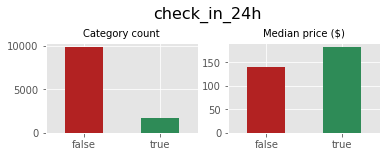

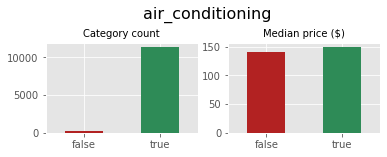

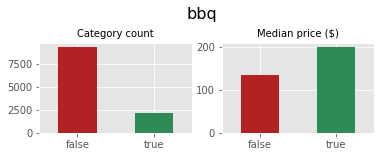

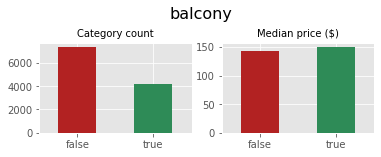

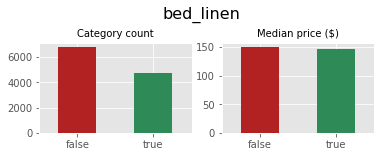

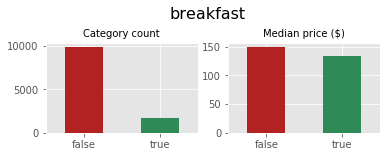

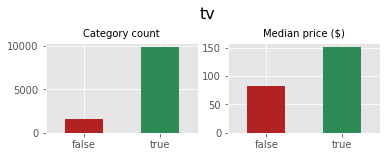

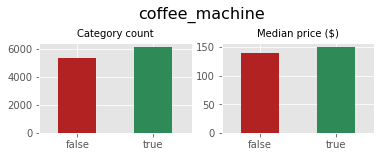

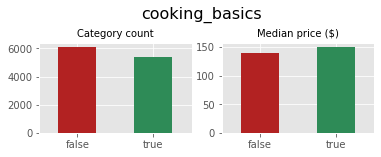

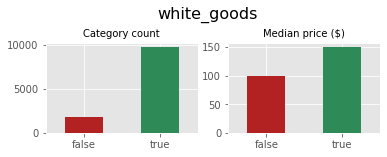

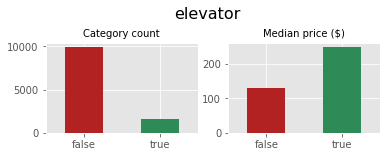

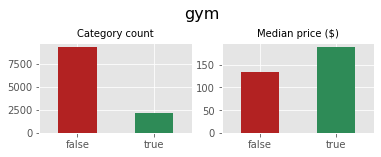

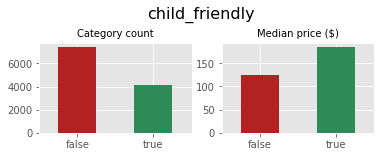

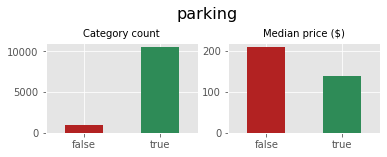

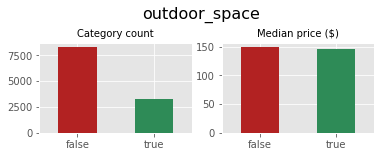

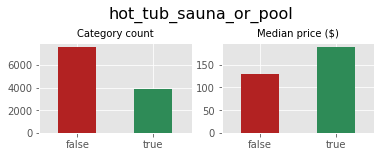

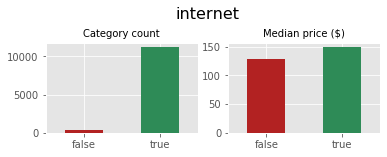

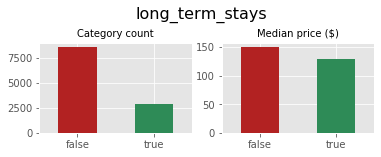

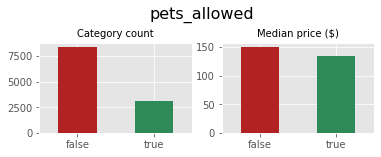

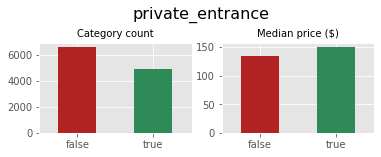

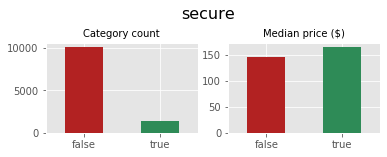

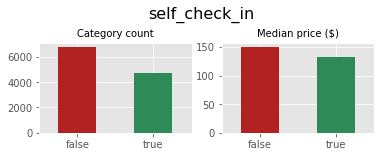

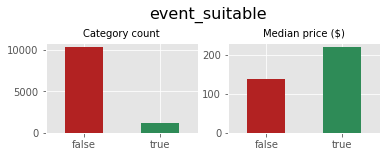

In [27]:
for col in df.iloc[:,42:65].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

_**7. What is the value of being a superhost? Is it worth getting verified?**_

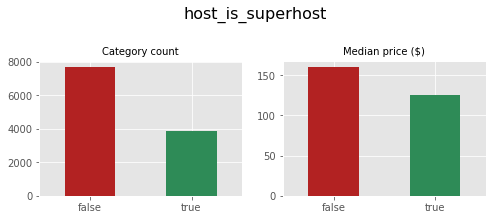

0.0    0.665306
1.0    0.334694
Name: host_is_superhost, dtype: float64


In [28]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

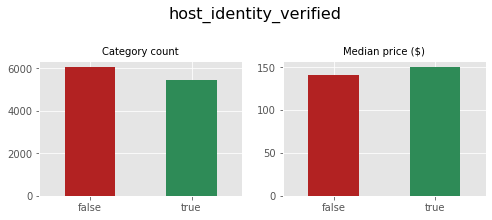

0.0    0.525786
1.0    0.474214
Name: host_identity_verified, dtype: float64


In [29]:
binary_count_and_price_plot('host_identity_verified')
print(df.host_identity_verified.value_counts(normalize=True))

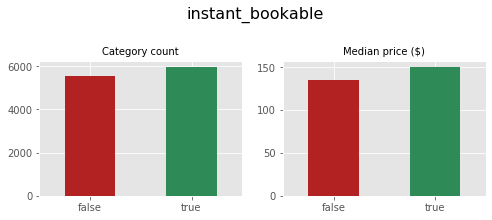

1    0.51684
0    0.48316
Name: instant_bookable, dtype: float64


In [30]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))